# Init

In [5]:
# %load_ext autoreload
import importlib
import pandas as pd
import os
import sys
import pwd
import numpy as np
from pathlib import Path
from tqdm import tqdm, trange
from tqdm.contrib.concurrent import process_map
import matplotlib.pyplot as plt
import GEOparse
import scanpy as sc
from scipy import sparse as sp
import sparse as spa
import scipy as spy
from scipy.stats import linregress, entropy
sys.path.append('../')
from meth import tools as mtools
from meth import analytic_tools as anatools
from meth.meth_anndata import AnnDataSet
from scipy.stats import pearsonr 
import sctools as sct
%load_ext autoreload
%autoreload 2
plt.style.use('meth.mplstyle')

# For lab meeting, various scenarios

In [295]:
sys.path.append('../')

from meth import analytic_tools as anatools

def generate_random_sample(Nsam=200, Ng = 500, empty_frac=0.2, noise_frac=0.2):
    # x = 1. * (np.random.randn(Nsam,Ng) > 0.5)
    x = generate_dynamics(0.2, 0.8)
    Nsam, Ng = x.shape[0], x.shape[1]
    xcov = np.random.randn(Nsam,Ng) * 0 + 1.
    if noise_frac > 0.5:
        idx = np.zeros(Nsam * Ng) == 0
        if noise_frac < 1.:
            idx[np.random.randint(0, Ng * Nsam, int(Nsam * Ng * (1-noise_frac)))] = False
    else:
        idx = np.zeros(Nsam * Ng) == 1
        if noise_frac > 0.:
            idx[np.random.randint(0, Ng * Nsam, int(Nsam * Ng * noise_frac))] = True
    
    if empty_frac > 0.5:
        jdx = np.zeros(Nsam * Ng) == 0
        if empty_frac < 1.:
            jdx[np.random.randint(0, Ng * Nsam, int(Nsam * Ng * (1-empty_frac)))] = False
    else:
        jdx = np.zeros(Nsam * Ng) == 1
        if empty_frac > 0:
            jdx[np.random.randint(0, Ng * Nsam, int(Nsam * Ng * empty_frac))] = True
        
    # idx = np.zeros(Nsam * Ng) == 1
    # idx[np.random.randint(0, Ng * Nsam, int(Nsam * Ng * 0.2))] = True

    idx = idx.reshape(Nsam,Ng)
    jdx = jdx.reshape(Nsam,Ng)
    z = x.copy()

    # x = np.random.rand(Nsam,Ng)
    # x[:,:50] = 1
    # x[::2,50:100] = 0
    # x[1::2,50:100] = 1
    # x[::2,100:150] = 1
    # x[1::2,100:150] = 0
    # x[:Nsam//2,150:200] = 0
    # x[Nsam//2:,150:200] = 1
    # x[:Nsam//2,200:250] = 1
    # x[Nsam//2:,200:250] = 0

    #for cross_entropy_by_batch
    # x[idx] = np.nan#np.nan#0#np.nanmedian(x[~idx])#np.nan
    # xcov[idx] = 0

    #for testing the effects of errors
    x[idx] = 1 - x[idx]#np.nan
    xcov[idx] = xcov[idx]

    x[jdx] = np.nan
    xcov[jdx] = 0

    x_sp = sp.csr_matrix(x)
    xt_sp = sp.csr_matrix(x.T)
    xcov_sp = sp.csr_matrix(xcov)

    x_sp_corr = sp.csr_matrix(np.nan_to_num(x))
    xt_sp_corr = sp.csr_matrix(np.nan_to_num(x.T))
    xcov_sp_corr = sp.csr_matrix(np.nan_to_num(xcov))
    y_true = np.zeros(Ng)
    y_true[:Ng//2] = 0
    y_true[Ng//2:] = 1
    y_true_mc = np.zeros((Ng, 3)) == 1
    y_true_mc[Ng//2, 0] = True
    y_true_mc[:Ng//2, 1] = True
    return x, xcov, x_sp_corr, xcov_sp_corr, y_true, y_true_mc
    
def generate_pics(perc):    
    CpS = 11
    # S = 5
    # Sx = 3
    # N = CpS * S
    # Nx = CpS * Sx
    N = 40
    Nx = 100
    y = np.zeros((N,Nx))
    y2 = np.zeros((N,Nx)) + 1
    # idx = np.random.randint(0, 2, y.flatten().shape[0])
    idx = np.zeros(N*Nx)
    idx[:int(N*Nx * perc)] = 1
    np.random.shuffle(idx)
    print(np.sum(idx), N*Nx*perc, N * Nx)
    y = (y.flatten() + 1 * idx).reshape((N,Nx))
    y2 = (y2.flatten() - 1 * idx).reshape((N,Nx))

    pic_stoch = np.hstack((y, y2))
    # y[idx] = 1-y[idx]
    # y2[idx] = 1-y2[idx]

    y = np.zeros((N,Nx))
    y2 = np.zeros((N,Nx)) + 1
    # idx = np.random.randint(0, 2, y.flatten().shape[0])
    idx = np.zeros(N)

    idx[:int(N * perc)] = 1
    np.random.shuffle(idx)
    idx = idx == 1
    y[idx,:] = 1 - y[idx,:]
    y2[idx,:] = 1 - y2[idx,:]
    # y[idx] = 1-y[idx]
    # y2[idx] = 1-y2[idx]
    pic_coreg = np.hstack((y, y2))
    
    return pic_stoch, pic_coreg


def generate_dynamics(meth_from, meth_to):
    pic_stoch_fr, pic_coreg_fr = generate_pics(meth_from)
    pic_stoch_to, pic_coreg_to = generate_pics(meth_to)
    return np.hstack((np.vstack((pic_stoch_fr, pic_stoch_to)), np.vstack((pic_coreg_fr, pic_coreg_to))))

pic = generate_dynamics(0.3, 0.7)

# def calc_quality_metrics(y_true, y_pred):
def find_coreg_regions_paper(ag_corr, ag_corr_you=None, ag_corr_old=None, corr_th = 0.5, clust_size=1.5):
    jdx_coreg = np.zeros(ag_corr.shape[0]) == 1
    for i in trange(ag_corr.shape[0]):
        idx = np.abs(ag_corr[i,:]) > corr_th
        if (ag_corr_old is not None) and (ag_corr_you is not None):
            idx_old_cpg = np.abs(ag_corr_old[i,:]) > corr_th
            idx_you_cpg = np.abs(ag_corr_you[i,:]) > corr_th
            idx = np.logical_and(idx, idx_old_cpg)
            idx = np.logical_and(idx, idx_you_cpg)
        if (np.sum(idx) > clust_size):
            jdx_coreg[idx] = True
    return jdx_coreg, np.logical_not(jdx_coreg)
    
def get_ytrue_ypred(empty_frac=0.2, noise_frac=0.2, corr_th=0.5, clust_size=1.5):
    x, xcov, x_sp, xcov_sp, y_true, y_true_mc = generate_random_sample(Nsam=200, Ng=500, empty_frac=empty_frac, noise_frac=noise_frac)
    Nsam, Ng = x.shape[0], x.shape[1]
    
    r_fast, r_cov_norm_fast = anatools.sparse_corr_mat_by_batch(x_sp, xcov_sp)
    r_fast_you, r_cov_norm_fast_you = anatools.sparse_corr_mat_by_batch(x_sp[:Nsam//2,:], xcov_sp[:Nsam//2,:])
    r_fast_old, r_cov_norm_fast_old = anatools.sparse_corr_mat_by_batch(x_sp[Nsam//2:,:], xcov_sp[Nsam//2:,:])
    
    
    jdx_coreg, jdx_stoch = find_coreg_regions_paper(r_fast, 
                                                    ag_corr_you=r_fast_you, 
                                                    ag_corr_old=r_fast_old,
                                                    corr_th=corr_th,
                                                   clust_size=clust_size)
    
    Ng = x.shape[1]
    y_pred = np.zeros(x.shape[1])
    y_pred[jdx_coreg] = 1
    y_pred[jdx_stoch] = 0
    
    y_pred_mc = np.zeros((Ng, 3)) == 1
    y_pred_mc[:, 0] = jdx_coreg
    y_pred_mc[:, 1] = jdx_stoch
    return y_true, y_true_mc, y_pred, y_pred_mc, x, xcov, jdx_coreg, jdx_stoch, r_fast, r_cov_norm_fast

1200.0 1200.0 4000
2800.0 2800.0 4000


In [372]:
def save_figs(x, y_pred, empty, noise, y_true, key='None'):
    fig, ax=  plt.subplots(3,1, sharex=True, dpi=300)
    ax[0].set_title(f'Simulated data, missed {empty * 100:.0f}%, errors {100* noise:.0f}%', fontsize=15)
    ax[0].imshow(x)#[:,::2])
    bg = np.zeros_like(x)
    ax[1].imshow((bg + y_pred) * 5., cmap='RdYlGn', alpha=0.5)#[:,::2])
    ax[1].set_title('Predicted co-regulated/stochastic label', fontsize=15)
    ax[2].set_title('True co-regulated/stochastic label', fontsize=15)
    ax[2].imshow((bg + y_true) * 5., cmap='RdYlGn', alpha=0.5)#[:,::2])
    [ax[i].axis('off') for i in range(3)]
    plt.savefig(f'PICS/png/{key}_Raw_data_empty_{empty}_noise_{noise}.png', dpi=300)
    plt.show()
    # plt.figure(dpi=300)
    # plt.imshow(x[:,y_pred == 0])
    # plt.savefig(f'PICS/png/{key}_Coreg_empty_{empty}_noise_{noise}.png', dpi=300)
    # plt.show()
    # plt.figure(dpi=300)
    # plt.imshow(x[:,y_pred == 1])
    # plt.savefig(f'PICS/png/{key}_Stoch_empty_{empty}_noise_{noise}.png', dpi=300)
    # plt.show()

800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 66547.21it/s]


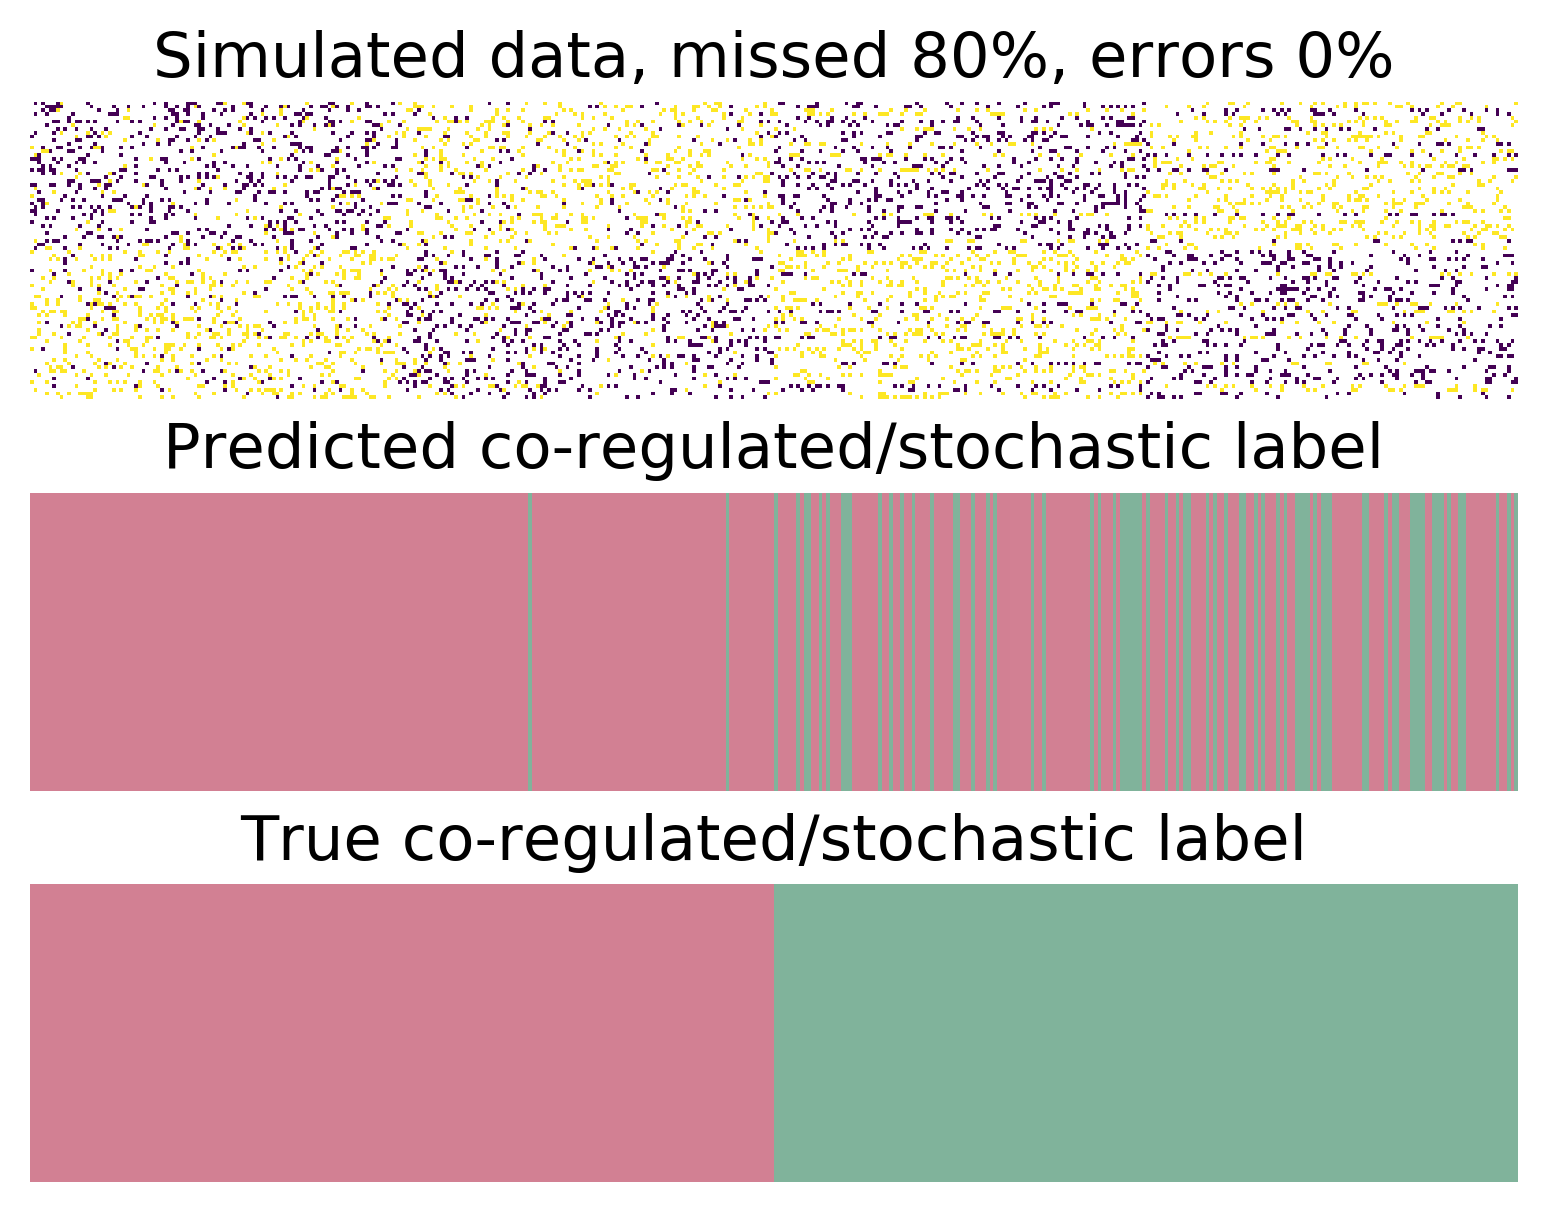

In [400]:
# empty, noise, corr_th = 0.4, 0.1, 0.4
# empty, noise, corr_th = 0.4, 0.1, 0.4

# empty, noise, corr_th, cs = 0.1, 0.1, 0.4, 1.5
# empty, noise, corr_th, cs = 0.8, 0.0, 0.4, 1.5
# empty, noise, corr_th, cs = 0.8, 0.1, 0.4, 1.5
# empty, noise, corr_th, cs = 0.4, 0.1, 0.4, 1.5
# empty, noise, corr_th, cs = 0.0, 0.2, 0.4, 1.5
# empty, noise, corr_th, cs = 0.2, 0.2, 0.4, 1.5
# empty, noise, corr_th, cs = 0.4, 0.2, 0.4, 1.5
# empty, noise, corr_th, cs = 0.6, 0.2, 0.4, 1.5
# empty, noise, corr_th, cs = 0.8, 0.2, 0.4, 1.5
# empty, noise, corr_th, cs = 0.0, 0.3, 0.4, 1.5
# empty, noise, corr_th, cs = 0.0, 0.4, 0.4, 1.5
# empty, noise, corr_th, cs = 0.2, 0.00, 0.4, 1.5
# empty, noise, corr_th, cs = 0.4, 0.00, 0.4, 1.5
# empty, noise, corr_th, cs = 0.6, 0.00, 0.4, 1.5
empty, noise, corr_th, cs = 0.8, 0.00, 0.4, 1.5
# empty, noise, corr_th, cs = 0.9, 0.00, 0.4, 1.5
adapt = False

y_true, y_true_mc, y_pred, y_pred_mc, x, xcov, jdx_coreg, jdx_stoch, r_fast, r_cov_norm_fast = get_ytrue_ypred(empty, noise, corr_th=corr_th, clust_size=cs)
r_fast = np.nan_to_num(r_fast)
r_fast[r_fast > 1.] = 1.
r_fast[r_fast < -1.] = -1.
save_figs(x, y_pred, empty, noise, y_true, key=f'Thres_{empty}_{noise}_{corr_th}')

In [306]:
# y_pred, y_pred_mc, y_true, y_true_mc

In [313]:
from sklearn.metrics import accuracy_score, f1_score

cov_lin = [0.0,  0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# noise_lin = [0.05, 0.1, 0.15, 0.3]
# corr_ths = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# cov_lin = [0.4]
noise_lin = [0.1]
corr_ths = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

accs = np.zeros((len(cov_lin), len(noise_lin), len(corr_ths)))
f1scores = np.zeros((len(cov_lin), len(noise_lin), len(corr_ths)))
for i, cl in enumerate(cov_lin):
    for j, nl in enumerate(noise_lin):
        for k, th in enumerate(corr_ths):
            y_true, y_true_mc, y_pred, y_pred_mc, x, xcov, jdx_coreg, jdx_stoch, r_fast, r_cov_norm_fast = get_ytrue_ypred(cl, nl, corr_th=corr_th)
            
            accs[i, j, k] = accuracy_score(y_true, jdx_coreg)
            f1scores[i, j, k] = f1_score(y_true, jdx_coreg)

800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 64821.95it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 60517.32it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 63600.65it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 62979.90it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 64567.49it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 59264.60it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 66383.95it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 60278.14it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 60330.17it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 65664.25it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 61554.21it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 58139.16it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 63845.10it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 64169.88it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 61219.54it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 59779.85it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 66489.18it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 64441.01it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 62025.27it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 61674.14it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 64726.91it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 62953.91it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 63017.75it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 62186.20it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 59176.81it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 63453.92it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 65836.90it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 62338.71it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 67001.66it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 60367.07it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 67937.70it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 65293.70it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 65469.51it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 65177.02it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 65242.92it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 64003.42it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 64054.73it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 64771.89it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 66592.11it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 61504.57it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 62692.78it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 68582.01it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 63658.57it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 67693.74it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 64532.72it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 67151.84it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 65656.54it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 66431.27it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 68576.40it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 62655.32it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 67803.17it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 69643.90it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 64669.53it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 58589.89it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 66958.88it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 63029.59it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 67527.53it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 63126.82it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 69167.28it/s]


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 66381.32it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 63114.95it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 64047.40it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 69687.29it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 70315.24it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 65136.53it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 70918.61it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 67122.29it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 63738.38it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 68208.38it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 67819.61it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 62538.55it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 71847.96it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 68624.08it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 66547.21it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 69353.13it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 69577.47it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 63552.47it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 67915.70it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 68714.02it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 72228.41it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
100%|██████████| 400/400 [00:00<00:00, 68205.61it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
100%|██████████| 400/400 [00:00<00:00, 64084.09it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 65917.08it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 67541.13it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 66586.82it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 71322.60it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
100%|██████████| 400/400 [00:00<00:00, 62739.67it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 67622.80it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 67302.70it/s]


800.0 800.0 4000
3200.0 3200.0 4000


/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|██████████| 400/400 [00:00<00:00, 70130.07it/s]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/an

800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 67405.45it/s]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 70039.31it/s]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 69350.26it/s]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 69050.57it/s]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 69600.56it/s]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 71380.26it/s]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 72293.77it/s]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 70620.10it/s]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 69913.81it/s]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:329: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:333: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:334: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:335: RuntimeWarning: divide by zero encountered in divide
  return cov_mat, 1./cov_norm


800.0 800.0 4000
3200.0 3200.0 4000


100%|██████████| 400/400 [00:00<00:00, 72638.07it/s]


In [314]:
accs.shape

(10, 1, 10)

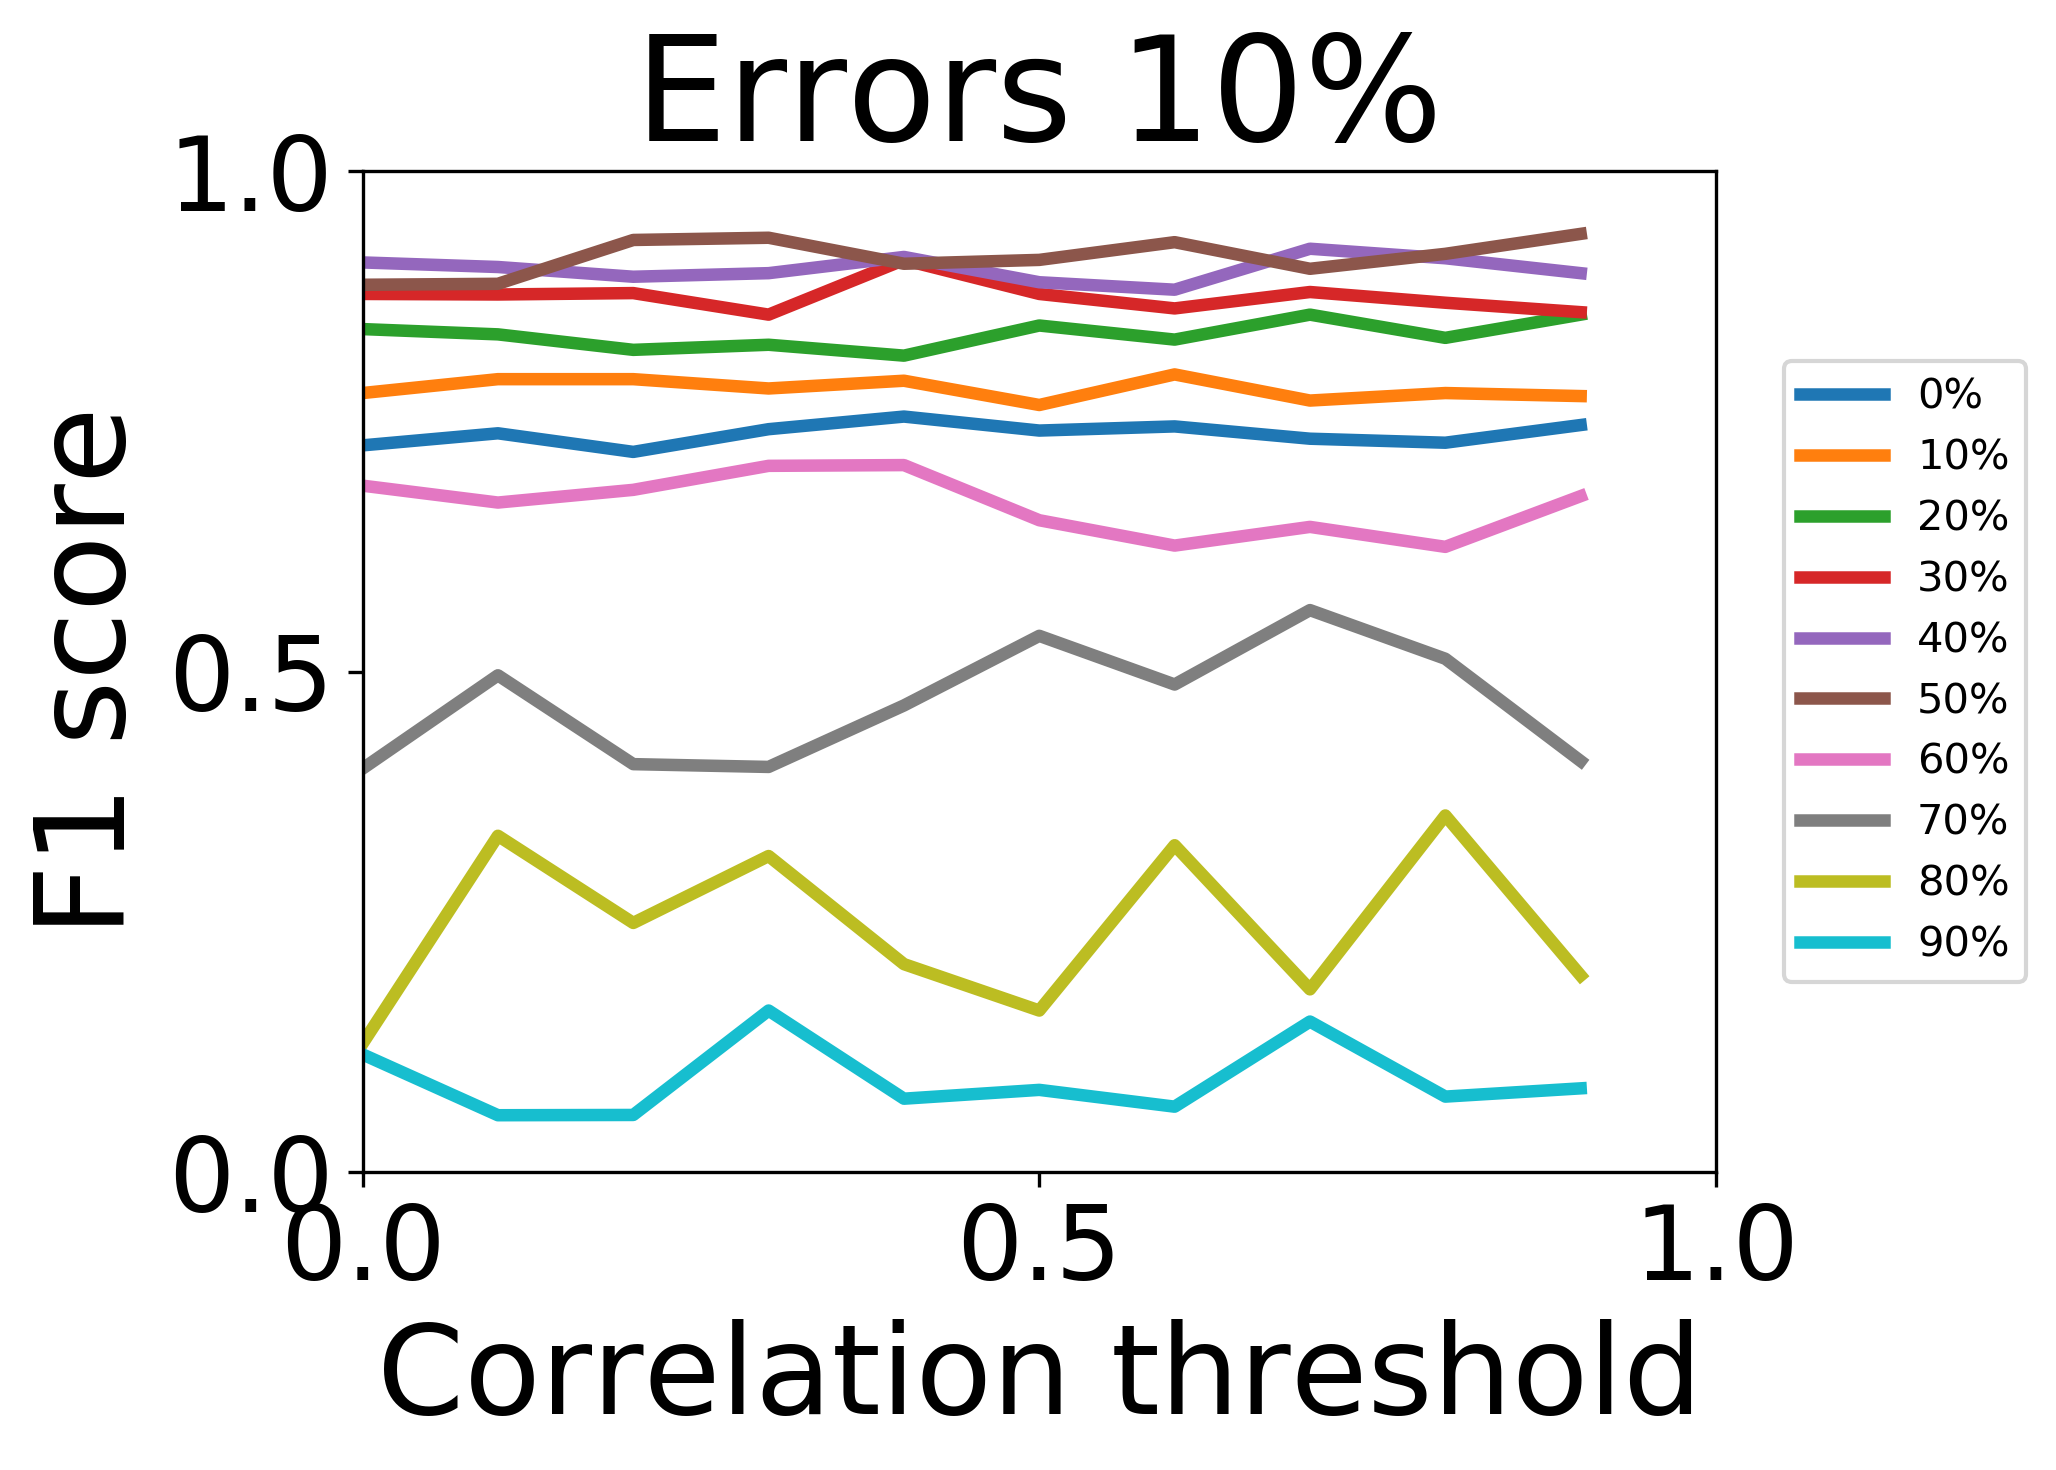

In [394]:
# fig, ax=  plt.subplots(3,1, sharex=True, dpi=300)
    
plt.figure(figsize=(7,5), dpi = 300)
for j, nl in enumerate(noise_lin):
    for i, cl in enumerate(cov_lin):
        plt.plot(corr_ths, f1scores[i,j,:], label=f"{cl * 100:.0f}%")
        # plt.plot(corr_ths, accs[i,j,:], label=f"Empty={cl}")
    plt.title(f"Errors {100*nl:.0f}%")
    plt.xlabel('Correlation threshold')
    plt.ylabel('F1 score')
    plt.xlim([0,1.])
    plt.ylim([0,1])
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    # plt.xticks([0,0.25, 0.5, 0.75, 1.])
    # plt.legend(fontsize=10)
    plt.legend(fontsize=10, loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(f'PICS/png/F1score_coreg_algorithm_error_{nl}.png')
    plt.show()

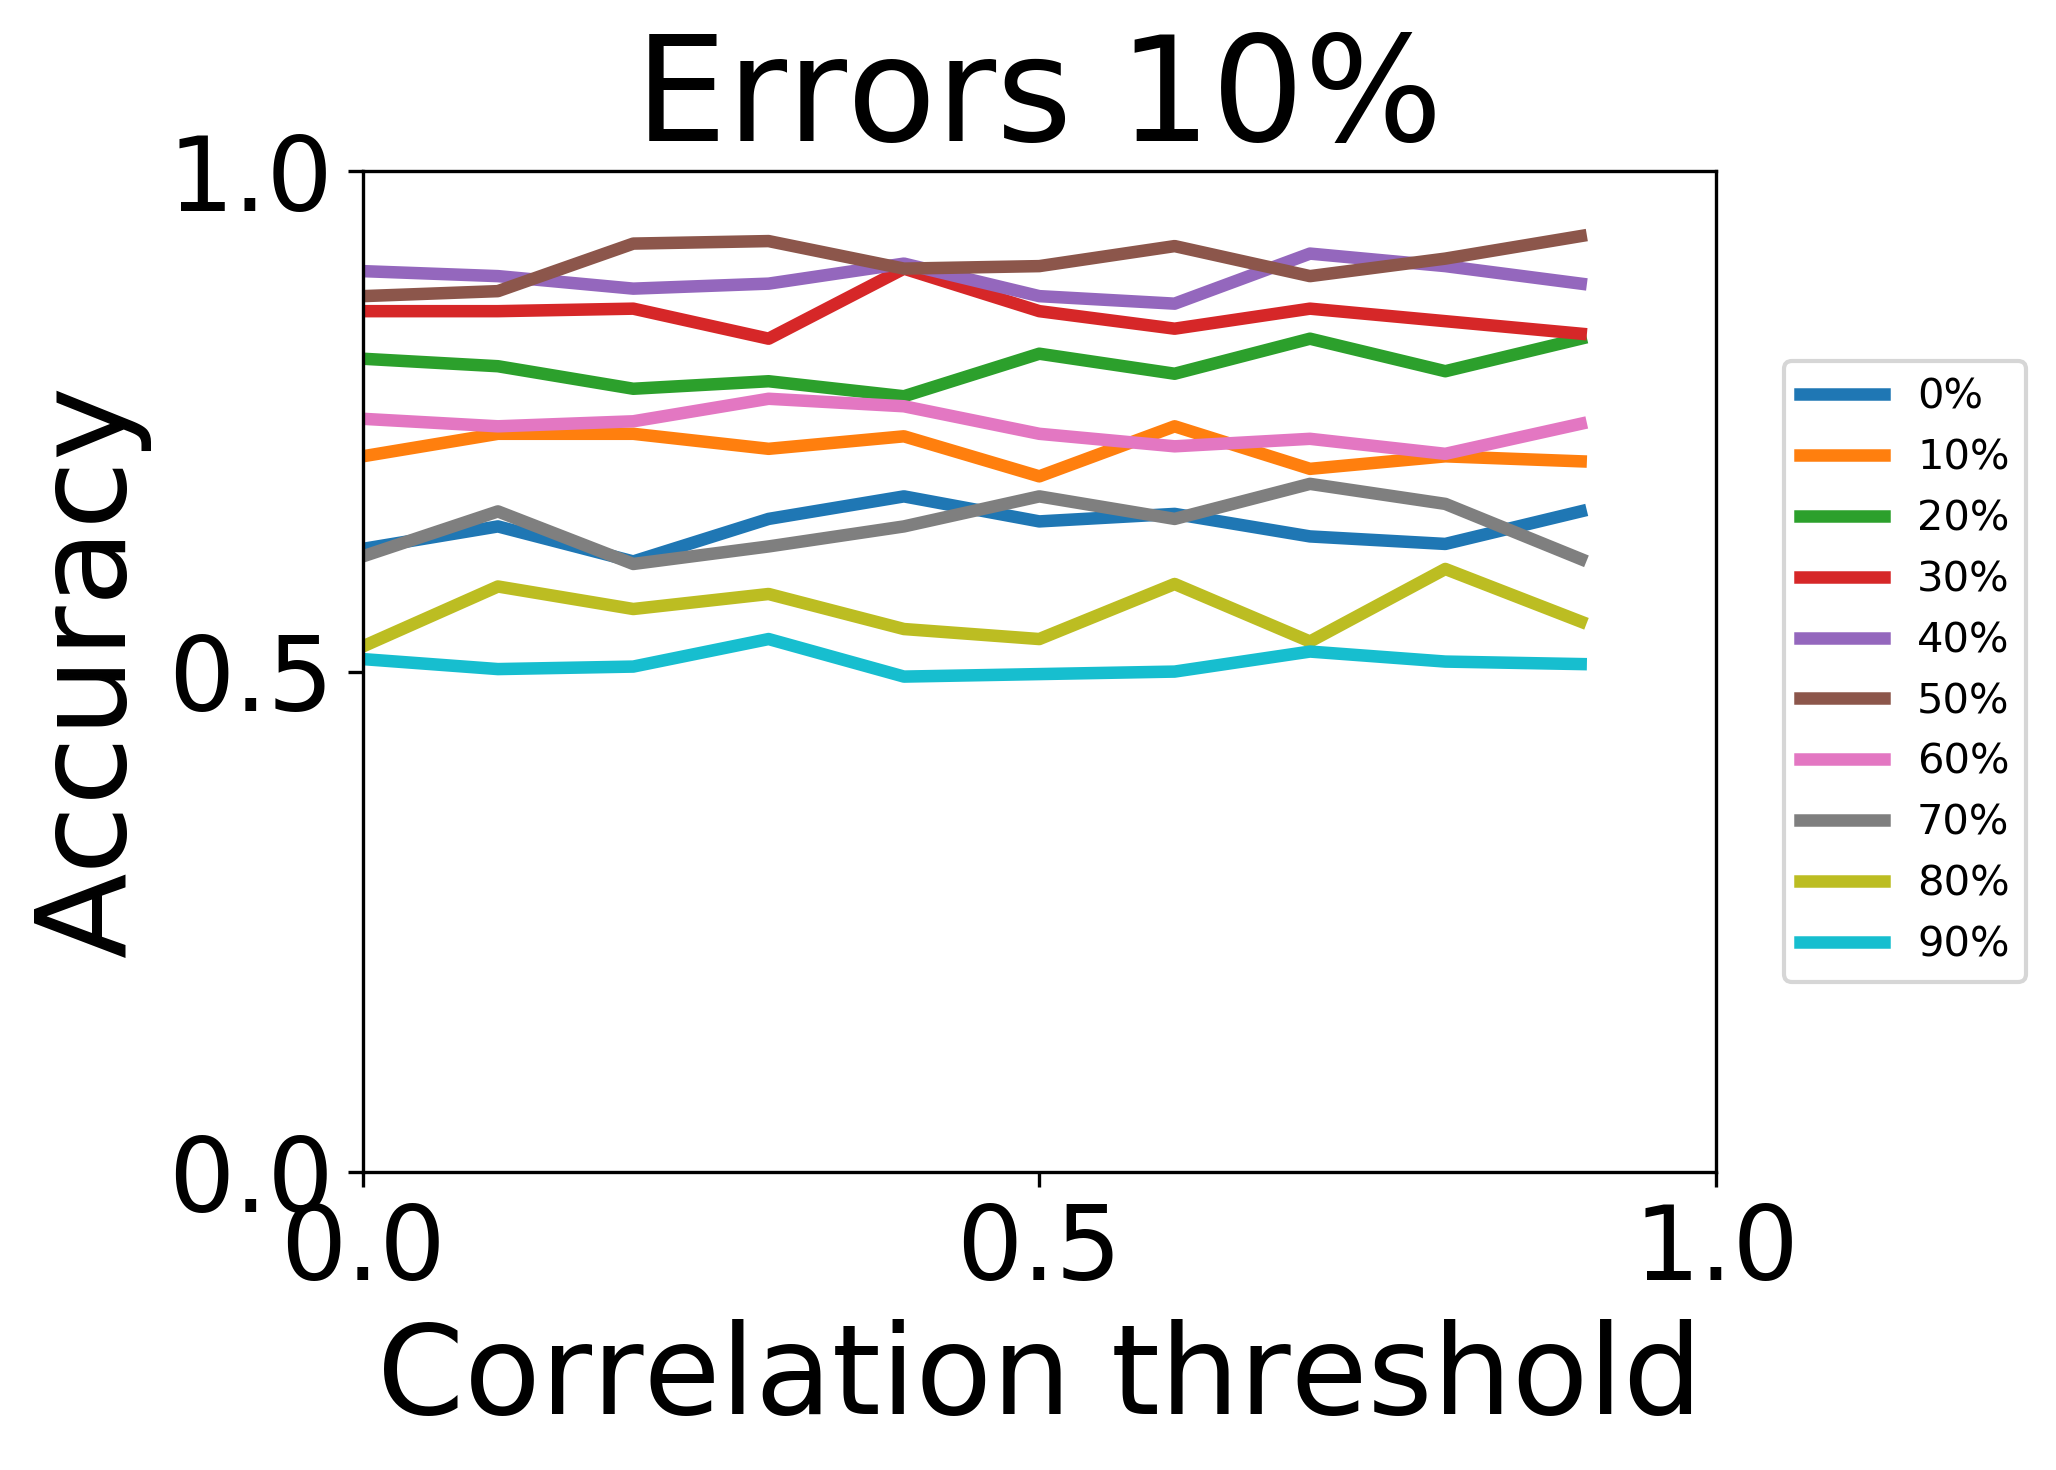

In [396]:
plt.figure(figsize=(7,5), dpi = 300)
for j, nl in enumerate(noise_lin):
    for i, cl in enumerate(cov_lin):
        # plt.plot(corr_ths, f1scores[i,j,:], label=f"{cl * 100:.0f}%")
        plt.plot(corr_ths, accs[i,j,:], label=f"{cl * 100:.0f}%")
    plt.title(f"Errors {100*nl:.0f}%")
    plt.xlabel('Correlation threshold')
    plt.ylabel('Accuracy')
    plt.xlim([0,1.])
    plt.ylim([0,1])
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    # plt.xticks([0,0.25, 0.5, 0.75, 1.])
    # plt.legend(fontsize=10)
    plt.legend(fontsize=10, loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(f'PICS/png/Accuracy_coreg_algorithm_error_{nl}.png')
    plt.show()